In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute('select * from Measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement.date).order_by(Measurement.id.desc()).first()

('2017-08-23')

In [13]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)


2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
date = dt.datetime(2016, 8, 23)

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > date).filter(Measurement.prcp).all()



In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True,)
prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-28,0.01
2016-08-31,0.13
2016-09-04,0.03


<function matplotlib.pyplot.show(*args, **kw)>

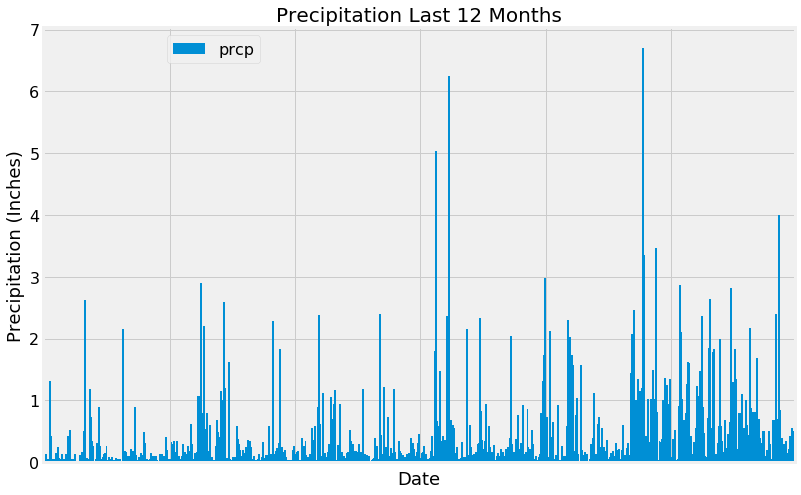

In [16]:

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Precipitation Last 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.show


![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,1142.000000
mean,0.311357
std,0.576134
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


![describe](Images/describe.png)

In [18]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct

session.query(Station.name).count()

9

In [76]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

low_hi_avg = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                        filter(Measurement.station == "USC00519281").all()
low_hi_avg


[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station  

date = dt.datetime(2016, 8, 23)

results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > date).filter(Measurement.station == "USC00519281").all()
results

hi_station_df = pd.DataFrame(results, columns=['date', 'tobs'])
hi_station_df.set_index('date', inplace=True,)
hi_station_df.head()

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


<function matplotlib.pyplot.show(*args, **kw)>

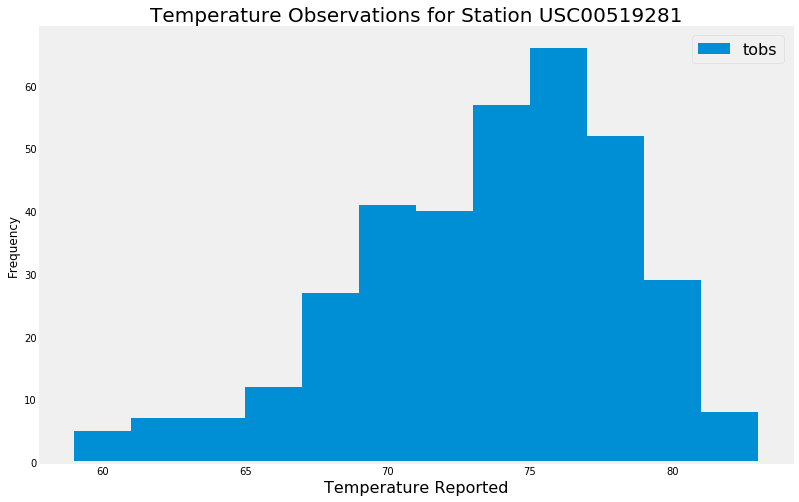

In [23]:
# plot the results as a histogram


hi_station_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Station " + "USC00519281", fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.show




![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2017-07-01', '2017-07-08')
trip_temp_df = pd.DataFrame(trip_temp, columns=['tmin', 'tavg', 'tmax'])
trip_temp_df.head()

,tmin,tavg,tmax
0,71.0,78.043478,87.0


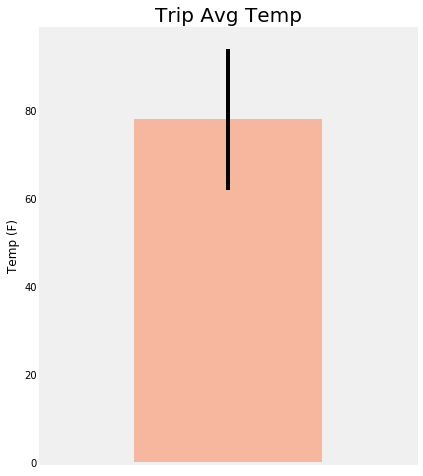

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = trip_temp_df['tavg']
min_max_temp = trip_temp_df.iloc[0]['tmax'] - trip_temp_df.iloc[0]['tmin']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()

In [79]:
# Calculate the total amount of rainfall per weather station for your trip 
# dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, 
# name, latitude, longitude, and elevation

from sqlalchemy import and_

def calc_prcp(start_date, end_date):
      
    y = session.query(func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
 
    return y
  
print(calc_prcp('2017-07-01', '2017-07-08'))

[(12.060000000000002, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (5.759999999999996, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (2.7899999999999983, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (1.0800000000000005, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (0.54, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (0.18, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (None, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
